# Social Network Analysis - Class 4 - Ego composition

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import QMSS as qmss

## Social circle and job satisfaction

In [3]:
# get the variables that we need from the data file
gss = pd.read_csv('Data/gss-nets.csv', usecols=['year', 'satjob', 'numgiven', 'year', 'educ', 'hapmar', 
                                                'age', 'marital', 'race', 'childs', 'sex',
                                                'cowork1', 'cowork2', 'cowork3','cowork4', 'cowork5', 
                                                'prestige', 'prestg80'])

In [7]:
# slide 25
# recoding and calculate new variables
gss['rsatjob'] = 5 - gss.satjob

cowork_cols = ['cowork1', 'cowork2', 'cowork3', 'cowork4', 'cowork5']

# create 'cw' columns
cw = []
for c in cowork_cols:
    c_num = c[-1:]
    cw_col = 'cw' + str(c_num)
    cw.append(cw_col)
    gss[cw_col] = np.where(pd.isnull(gss[c]), np.nan, 
                           np.where(gss[c]==1, 1, 0))

gss['pctcw'] = gss[cw].mean(axis=1)

gss.pctcw.describe()

count    5264.000000
mean        0.132228
std         0.258821
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         1.000000
Name: pctcw, dtype: float64

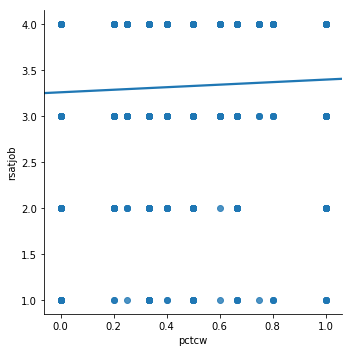

In [13]:
# slide 22
sns.lmplot(x='pctcw', y='rsatjob', data=gss, ci=False)

In [68]:
# slide 26
## get the maximum occupation prestige score between "prestige" and "prestg80"

gss['maxpr'] = gss[['prestige', 'prestg80']].apply(lambda x: x.max(), axis=1)

In [70]:
from statsmodels.iolib.summary2 import summary_col

lm1 = smf.ols('rsatjob ~ pctcw + numgiven', data=gss[gss.maxpr>-1]).fit()
lm2 = smf.ols('rsatjob ~ pctcw + numgiven + C(year) + educ + age + \
               maxpr + C(marital) + C(race) + childs + sex', data=gss[gss.maxpr>-1]).fit()
lm3 = smf.ols('rsatjob ~ pctcw*maxpr + numgiven + C(year) + educ + age + \
               C(race) + childs + sex', data=gss[gss.maxpr>-1]).fit()

summary_col([lm1, lm2, lm3], stars=True)

,rsatjob I,rsatjob II,rsatjob III
C(marital)[T.2.0],,-0.0384,
,,(0.0687),
C(marital)[T.3.0],,-0.0815**,
,,(0.0407),
C(marital)[T.4.0],,0.1050,
,,(0.0726),
C(marital)[T.5.0],,-0.0775*,
,,(0.0408),
C(race)[T.2],,-0.1341***,-0.1446***
,,(0.0389),(0.0379)


In [86]:
# slide 37
# construct a dataframe to plot the relationship between different levels of prestige
prest_dat = pd.DataFrame({'pct_cw': gss.pctcw})

prest_dat['prestige0'] = lm3.params.Intercept + lm3.params.pctcw*prest_dat.pct_cw
prest_dat['prestige50'] = lm3.params.Intercept + lm3.params.pctcw*prest_dat.pct_cw + \
                          lm3.params.maxpr*50 + lm3.params['pctcw:maxpr']*50*prest_dat.pct_cw
prest_dat['prestige100'] = lm3.params.Intercept + lm3.params.pctcw*prest_dat.pct_cw + \
                          lm3.params.maxpr*100 + lm3.params['pctcw:maxpr']*100*prest_dat.pct_cw

# convert to long format in order to use the 'hue' argument in sns.lmplot
prest_dat = pd.melt(prest_dat, id_vars=['pct_cw'], value_vars=['prestige0', 'prestige50', 'prestige100'])
prest_dat.rename(columns={'value':'rsatjob'}, inplace=True)

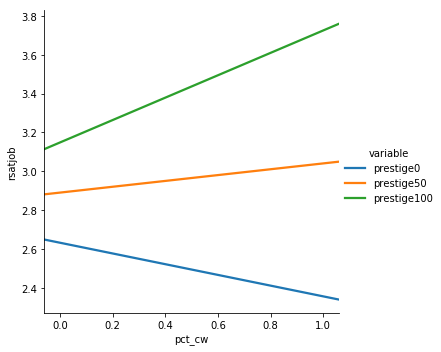

In [88]:
sns.lmplot(x='pct_cw', y='rsatjob', hue='variable', data=prest_dat, scatter=False, ci=False)

In [93]:
# slide 40 

gss['rhapmar'] = 4 - gss.hapmar

lm4 = smf.ols('rsatjob ~ pctcw + numgiven + C(year) + educ + age + maxpr + C(race) + childs + sex', 
              data=gss[(gss.maxpr>-1) & (gss.marital==1)]).fit()
lm5 = smf.ols('rsatjob ~ pctcw*maxpr + numgiven + C(year) + educ + age + C(race) + childs + sex',
              data=gss[(gss.maxpr>-1) & (gss.marital==1)]).fit()
lm6 = smf.ols('rhapmar ~ pctcw + numgiven + C(year) + educ + age + maxpr + C(race) + childs + sex',
              data=gss[(gss.maxpr>-1) & (gss.marital==1)]).fit()

summary_col([lm4, lm5, lm6], stars=True) 

,rsatjob I,rsatjob II,rhapmar I
C(race)[T.2],-0.1391**,-0.1404**,-0.1909***
,(0.0576),(0.0575),(0.0392)
C(race)[T.3],-0.1070,-0.1028,-0.0332
,(0.0823),(0.0821),(0.0611)
C(year)[T.1987],-0.0709*,-0.0731*,0.1033***
,(0.0416),(0.0415),(0.0280)
C(year)[T.2004],0.0461,0.0563,-0.0000***
,(0.0667),(0.0667),(0.0000)
C(year)[T.2010],0.0351,0.0466,-0.0034
,(0.0493),(0.0493),(0.0324)


## Diversity in social networks 

In [95]:
gss2 = pd.read_csv('Data/gss-nets.csv', usecols=['year', 'region', 'race', 'sex', 'marital',
                                                 'race1', 'race2', 'race3', 'race4', 'race5', 
                                                 'sex1', 'sex2', 'sex3', 'sex4', 'sex5'])

In [119]:
# slide 49 - recoding variables

race_cols = ['race1', 'race2', 'race3', 'race4', 'race5']

newrace_cols = []
for c in race_cols:
    c_num = c[-1:]
    new_col = 'newrace' + str(c_num)
    newrace_cols.append(new_col)
    gss2[new_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                               np.where(gss2[c]==4, 1, 0))

gss2['pctwht'] = gss2[newrace_cols].mean(axis=1)

gss2['bigreg'] = gss2.region.map({1: 'northeast', 2: 'northeast',
                                  3: 'midwest', 4: 'midwest', 
                                  5: 'south', 6: 'south', 7: 'south', 
                                  8: 'west', 9: 'west'})

gss2['bigreg'] = gss2.bigreg.astype('category').cat.reorder_categories(['northeast', 'midwest', 
                                                                        'south', 'west'])

Text(0,0.5,'pctwht')

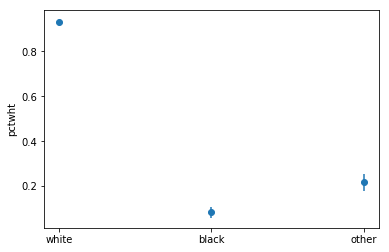

In [142]:
# slide 51
lm_pctwht = smf.ols('pctwht ~ C(race)', data=gss2).fit()

gss2['race_cat'] = gss2.race.map({1:'white', 2:'black', 3:'other'})
gss2['race_cat'] = gss2.race_cat.astype('category').cat.reorder_categories(['white', 'black', 'other'])
race_mean = gss2.groupby('race_cat')['pctwht'].mean()
race_bse = lm_pctwht.bse

plt.errorbar(x=race_mean.index, y=race_mean, yerr=1.96*race_bse, marker='o', linestyle='')
plt.ylabel('pctwht')

In [121]:
# slide 54

arace_cols = []
brace_cols = []
hrace_cols = []
orace_cols = []
for c in race_cols:
    c_num = c[-1:]
    
    # a-race
    a_col = 'arace' + str(c_num)
    arace_cols.append(a_col)
    gss2[a_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==1, 1, 0))
    
    # b-race
    b_col = 'brace' + str(c_num)
    brace_cols.append(b_col)
    gss2[b_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==2, 1, 0))
    
    # h-race
    h_col = 'hrace' + str(c_num)
    hrace_cols.append(h_col)
    gss2[h_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==3, 1, 0))
    
    # o-race
    o_col = 'orace' + str(c_num)
    orace_cols.append(o_col)
    gss2[o_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==5, 1, 0))
    
    
gss2['pctas'] = gss2[arace_cols].mean(axis=1)
gss2['pctbl'] = gss2[brace_cols].mean(axis=1)
gss2['pcthis'] = gss2[hrace_cols].mean(axis=1)
gss2['pctoth'] = gss2[orace_cols].mean(axis=1)

In [123]:
gss2['hhi'] = np.square(gss2.pctwht) + np.square(gss2.pctas) + np.square(gss2.pctbl) + \
       np.square(gss2.pcthis) + np.square(gss2.pctoth)

hhi_df = gss2.groupby(['race_cat', 'bigreg'])['hhi'].mean().to_frame('mean hhi')

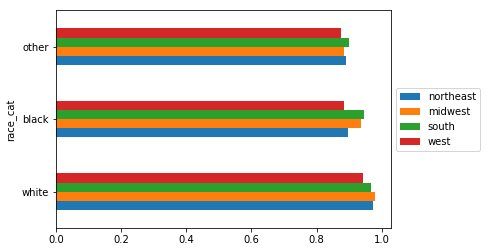

In [140]:
hhi_df.unstack().plot.barh(y='mean hhi').legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [144]:
# slide 59

sex_cols = ['sex1', 'sex2', 'sex3', 'sex4', 'sex5']

male_cols = []
female_cols = []
for c in sex_cols:
    c_num = c[-1:]
    
    # male
    m_col = 'msex' + str(c_num)
    male_cols.append(m_col)
    gss2[m_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==1, 1, 0))
    
    # female
    w_col = 'w' + str(c_num)
    female_cols.append(w_col)
    gss2[w_col] = np.where(pd.isnull(gss2[c]), np.nan, 
                           np.where(gss2[c]==2, 1, 0))

    
    
gss2['pctmale'] = gss2[male_cols].mean(axis=1)
gss2['pctfe'] = gss2[female_cols].mean(axis=1)

gss2['hhisex'] = np.square(gss2.pctmale) + np.square(gss2.pctfe)

gss2['mar'] = gss2.marital.map({1:'married', 2:'once married', 3:'once married', 4:'once married', 5:'never married'})
gss2['mar'] = gss2.mar.astype('category').cat.reorder_categories(['married', 'once married', 'never married'])

Text(0,0.5,'hhisex')

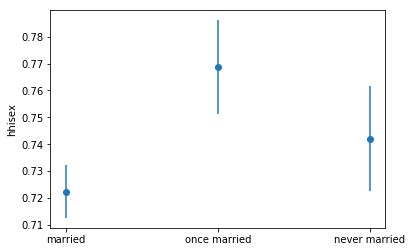

In [145]:
# slide 51
lm_hhisex = smf.ols('hhisex ~ C(mar)', data=gss2).fit()

hhisex_mean = gss2.groupby('mar')['hhisex'].mean()
hhisex_bse = lm_hhisex.bse

plt.errorbar(x=hhisex_mean.index, y=hhisex_mean, yerr=1.96*hhisex_bse, marker='o', linestyle='')
plt.ylabel('hhisex')

## Measures of cohesion - Lazega law firm data

Follows starting from slide 107. For code that covers slides 74-87, scroll further down. 

Note that you might run into errors depending on your version of the modules. The below code rely on Pandas 0.23.4 and patsy 0.5.1.

In [3]:
lazega_attr = pd.read_csv('Data/Lazega-Atts.csv')

test = pd.read_csv('Data/Lazega-Advice-Net.csv', skiprows=1, names=list(np.arange(1, 72)))
test.index = list(np.arange(1, 72))

In [4]:
import networkx as nx

# generate undirected graph
G = nx.from_pandas_adjacency(test)

# attach attributes to vertices
lazega_attr = lazega_attr.set_index('ID')
attr_dict = lazega_attr.to_dict('index')
nx.set_node_attributes(G, attr_dict)

In [12]:
test.head(20)

,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
lazega_attr.head(20)

,status,gender,office,seniority,age,practice,lawschool
ID,,,,,,,
1,1,1,1,31,64,1,1
2,1,1,1,32,62,2,1
3,1,1,2,13,67,1,1
4,1,1,1,31,59,2,3
5,1,1,2,31,59,1,2
6,1,1,2,29,55,1,1
7,1,1,2,29,63,2,3
8,1,1,1,28,53,1,3
9,1,1,1,25,53,2,1


In [5]:
edges = list(nx.edges(G))

# create edges df. The Python graph is undirected. To make directed edges list, we reverse the columns
dir_e = pd.DataFrame(edges, columns=['V2', 'V1'])
dir_e = dir_e[['V1', 'V2']].copy()
dir_e = dir_e.sort_values(['V1', 'V2']).reset_index(drop=True)

In [14]:
dir_e.head(20)

,V1,V2
0,1,2
1,1,4
2,1,5
3,1,8
4,1,11
5,1,16
6,1,17
7,1,20
8,1,30
9,1,35


In [6]:
# slide 115

undir_e = pd.DataFrame(edges, columns=['V1', 'V2'])

mydata = dir_e.append(undir_e)
mydata = mydata.rename(columns={"V1": "ID1", "V2": "ID2"})

In [7]:
# slide 116
## append attribute info for each node
all_df = pd.merge(mydata, lazega_attr, left_on='ID1', right_on='ID')
all_df = pd.merge(all_df, lazega_attr, left_on='ID2', right_on='ID', suffixes=('_1', '_2'))

In [17]:
all_df.head()

,ID1,ID2,status_1,gender_1,office_1,seniority_1,age_1,practice_1,lawschool_1,status_2,gender_2,office_2,seniority_2,age_2,practice_2,lawschool_2
0,1,2,1,1,1,31,64,1,1,1,1,1,32,62,2,1
1,3,2,1,1,2,13,67,1,1,1,1,1,32,62,2,1
2,4,2,1,1,1,31,59,2,3,1,1,1,32,62,2,1
3,6,2,1,1,2,29,55,1,1,1,1,1,32,62,2,1
4,7,2,1,1,2,29,63,2,3,1,1,1,32,62,2,1


In [8]:
# slide 118
## Make homophily measures
all_df['homog'] = np.where(all_df.gender_1==all_df.gender_2, 1, 0)
all_df['homos'] = np.where(all_df.status_1==all_df.status_2, 1, 0)

# slide 119
## turn IDs to categories
all_df['ID1'] = all_df.ID1.astype('category')
all_df['ID2'] = all_df.ID2.astype('category')

## aggregate by ID1
aggdata = all_df.groupby('ID1').mean()

In [9]:
aggdata.head()

,status_1,gender_1,office_1,seniority_1,age_1,practice_1,lawschool_1,status_2,gender_2,office_2,seniority_2,age_2,practice_2,lawschool_2,homog,homos
ID1,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,31.0,64.0,1.0,1.0,1.230769,1.153846,1.384615,18.153846,47.692308,1.461538,1.769231,0.846154,0.769231
2,1.0,1.0,1.0,32.0,62.0,2.0,1.0,1.173913,1.130435,1.434783,16.217391,46.782609,1.565217,1.956522,0.869565,0.826087
3,1.0,1.0,2.0,13.0,67.0,1.0,1.0,1.083333,1.083333,1.666667,15.583333,47.583333,1.583333,2.000000,0.916667,0.916667
4,1.0,1.0,1.0,31.0,59.0,2.0,3.0,1.266667,1.166667,1.366667,13.600000,46.433333,1.433333,1.800000,0.833333,0.733333
5,1.0,1.0,2.0,31.0,59.0,1.0,2.0,1.222222,1.222222,1.555556,15.444444,46.777778,1.111111,2.000000,0.777778,0.777778


In [10]:
# slide 121
smf.ols('homog ~ C(gender_1)', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     75.33
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           1.15e-12
Time:                        12:55:40   Log-Likelihood:                 13.810
No. Observations:                  71   AIC:                            -23.62
Df Residuals:                      69   BIC:                            -19.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7205      0.028     25.960      0.000       0.665       0.776
C(gender_1)[T.2.0]    -0.4784      0.055     -8.679      0.000      -0.588      -0.368
==============================================================================
Omnibus:                       28.266   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.820
Skew:                          -1.197   Prob(JB):                     2.08e-17
Kurtosis:                       7.498   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# slide 122
# calculate degree 
degree = dict(nx.degree(G))

aggdata['degree'] = aggdata.index.map(degree)

In [12]:
smf.ols('homog ~ C(gender_1) + degree', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     42.30
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           1.16e-12
Time:                        12:55:51   Log-Likelihood:                 16.307
No. Observations:                  71   AIC:                            -26.61
Df Residuals:                      68   BIC:                            -19.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6202      0.053     11.805      0.000       0.515       0.725
C(gender_1)[T.2.0]    -0.4694      0.054     -8.732      0.000      -0.577      -0.362
degree                 0.0062      0.003      2.226      0.029       0.001       0.012
==============================================================================
Omnibus:                       14.529   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.313
Skew:                          -0.474   Prob(JB):                     2.91e-09
Kurtosis:                       6.520   Cond. No.                         46.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# slide 124
# calculate density of the ego network 

density = dict(nx.clustering(G))
aggdata['transitivity'] = aggdata.index.map(density)

In [14]:
# slide 125
smf.ols('homog ~ C(gender_1) + degree + transitivity', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     39.45
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           8.35e-15
Time:                        12:56:15   Log-Likelihood:                 23.735
No. Observations:                  71   AIC:                            -39.47
Df Residuals:                      67   BIC:                            -30.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4019      0.073      5.505      0.000       0.256       0.548
C(gender_1)[T.2.0]    -0.4369      0.049     -8.831      0.000      -0.536      -0.338
degree                 0.0045      0.003      1.760      0.083      -0.001       0.010
transitivity           0.6297      0.159      3.949      0.000       0.311       0.948
==============================================================================
Omnibus:                       13.863   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               38.135
Skew:                           0.421   Prob(JB):                     5.24e-09
Kurtosis:                       6.490   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# slide 126 - view the final dataframe
aggdata.head()

,status_1,gender_1,office_1,seniority_1,age_1,practice_1,lawschool_1,status_2,gender_2,office_2,seniority_2,age_2,practice_2,lawschool_2,homog,homos,degree,transitivity
ID1,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,31.0,64.0,1.0,1.0,1.230769,1.153846,1.384615,18.153846,47.692308,1.461538,1.769231,0.846154,0.769231,13,0.500000
2,1.0,1.0,1.0,32.0,62.0,2.0,1.0,1.173913,1.130435,1.434783,16.217391,46.782609,1.565217,1.956522,0.869565,0.826087,23,0.418972
3,1.0,1.0,2.0,13.0,67.0,1.0,1.0,1.083333,1.083333,1.666667,15.583333,47.583333,1.583333,2.000000,0.916667,0.916667,12,0.530303
4,1.0,1.0,1.0,31.0,59.0,2.0,3.0,1.266667,1.166667,1.366667,13.600000,46.433333,1.433333,1.800000,0.833333,0.733333,30,0.455172
5,1.0,1.0,2.0,31.0,59.0,1.0,2.0,1.222222,1.222222,1.555556,15.444444,46.777778,1.111111,2.000000,0.777778,0.777778,9,0.361111


## We can also run the above steps using the `igraph` module

In [26]:
lazega_attr = pd.read_csv('Data/Lazega-Atts.csv')

test = pd.read_csv('Data/Lazega-Friends.csv', skiprows=1, names=list(np.arange(1, 72)))
test.index = list(np.arange(1, 72))

In [27]:
import igraph as ig

g = ig.Graph.Adjacency((test.values>0).tolist())
g.vs['label'] = test.index

In [28]:
# slide 111
for c in lazega_attr.columns:
    g.vs[c] = lazega_attr.loc[lazega_attr.ID==g.vs['label'], c]

In [29]:
# slide 115
## create dataframe containing undirected edgelists 
e = pd.DataFrame(g.get_edgelist(), columns=['ID1', 'ID2'])+1

e2 = e[['ID2', 'ID1']]
e2.rename(columns={'ID2': 'ID1', 'ID1': 'ID2'}, inplace=True)

mydata = e.append(e2)

In [30]:
# slide 116
## append attribute info for each node
all_df = pd.merge(mydata, lazega_attr, left_on='ID1', right_on='ID')
all_df = pd.merge(all_df, lazega_attr, left_on='ID2', right_on='ID', suffixes=('_1', '_2'))

In [31]:
all_df.head()

,ID1,ID2,ID_1,status_1,gender_1,office_1,seniority_1,age_1,practice_1,lawschool_1,ID_2,status_2,gender_2,office_2,seniority_2,age_2,practice_2,lawschool_2
0,1,41,1,1,1,1,31,64,1,1,41,2,1,1,5,31,1,2
1,1,41,1,1,1,1,31,64,1,1,41,2,1,1,5,31,1,2
2,3,41,3,1,1,2,13,67,1,1,41,2,1,1,5,31,1,2
3,4,41,4,1,1,1,31,59,2,3,41,2,1,1,5,31,1,2
4,4,41,4,1,1,1,31,59,2,3,41,2,1,1,5,31,1,2


In [32]:
# slide 118
## Make homophily measures
all_df['homog'] = np.where(all_df.gender_1==all_df.gender_2, 1, 0)
all_df['homos'] = np.where(all_df.status_1==all_df.status_2, 1, 0)

# slide 119
## turn IDs to categories
all_df['ID1'] = all_df.ID1.astype('category')
all_df['ID2'] = all_df.ID2.astype('category')

## aggregate by ID1
aggdata = all_df.groupby('ID1').mean()

In [33]:
aggdata.head()

,ID_1,status_1,gender_1,office_1,seniority_1,age_1,practice_1,lawschool_1,ID_2,status_2,gender_2,office_2,seniority_2,age_2,practice_2,lawschool_2,homog,homos
ID1,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,31.0,64.0,1.0,1.0,38.500000,1.500000,1.272727,1.090909,8.454545,39.318182,1.136364,2.227273,0.727273,0.500000
2,2.0,1.0,1.0,1.0,32.0,62.0,2.0,1.0,35.357143,1.428571,1.500000,1.142857,9.642857,42.785714,1.571429,2.071429,0.500000,0.571429
3,3.0,1.0,1.0,2.0,13.0,67.0,1.0,1.0,43.307692,1.615385,1.076923,1.307692,7.230769,36.615385,1.307692,2.384615,0.923077,0.384615
4,4.0,1.0,1.0,1.0,31.0,59.0,2.0,3.0,39.520000,1.520000,1.240000,1.160000,8.480000,38.440000,1.520000,2.240000,0.760000,0.480000
5,5.0,1.0,1.0,2.0,31.0,59.0,1.0,2.0,41.448276,1.517241,1.206897,1.620690,7.137931,34.586207,1.275862,2.344828,0.793103,0.482759


In [34]:
# slide 121
smf.ols('homog ~ C(gender_1)', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     227.4
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           1.58e-23
Time:                        13:00:38   Log-Likelihood:                 47.442
No. Observations:                  71   AIC:                            -90.88
Df Residuals:                      69   BIC:                            -86.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7787      0.017     45.055      0.000       0.744       0.813
C(gender_1)[T.2.0]    -0.5176      0.034    -15.079      0.000      -0.586      -0.449
==============================================================================
Omnibus:                        1.641   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                1.040
Skew:                          -0.265   Prob(JB):                        0.595
Kurtosis:                       3.266   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# slide 122
aggdata['degree'] = g.degree()

In [36]:
# slide 123

smf.ols('homog ~ gender_1 + degree', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           3.01e-22
Time:                        13:00:42   Log-Likelihood:                 47.442
No. Observations:                  71   AIC:                            -88.88
Df Residuals:                      68   BIC:                            -82.10
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2975      0.061     21.128      0.000       1.175       1.420
gender_1      -0.5177      0.035    -14.810      0.000      -0.588      -0.448
degree     -4.017e-05      0.001     -0.028      0.978      -0.003       0.003
==============================================================================
Omnibus:                        1.694   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.086
Skew:                          -0.272   Prob(JB):                        0.581
Kurtosis:                       3.268   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# slide 124
aggdata['transitivity'] = g.transitivity_local_undirected()

In [38]:
smf.ols('homog ~ gender_1 + degree + transitivity', data=aggdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homog   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     77.92
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           8.32e-22
Time:                        13:00:46   Log-Likelihood:                 49.008
No. Observations:                  71   AIC:                            -90.02
Df Residuals:                      67   BIC:                            -80.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4713      0.117     12.586      0.000       1.238       1.705
gender_1        -0.5280      0.035    -15.106      0.000      -0.598      -0.458
degree          -0.0015      0.002     -0.906      0.368      -0.005       0.002
transitivity    -0.3738      0.215     -1.738      0.087      -0.803       0.055
==============================================================================
Omnibus:                        4.734   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.919
Skew:                          -0.543   Prob(JB):                        0.141
Kurtosis:                       3.383   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Only looking at outgoing ties

In [47]:
# make directed graph
G = nx.from_pandas_adjacency(test, create_using=nx.DiGraph())

# make dataframe for outgoing edges
out_edge = pd.DataFrame(list(G.out_edges), columns=['ID1', 'ID2'])

In [48]:
out_edge = pd.merge(out_edge, lazega_attr, left_on='ID1', right_on='ID')
out_edge = pd.merge(out_edge, lazega_attr, left_on='ID2', right_on='ID', suffixes=('_1', '_2'))

## drop duplicated IDs resulted from the merge function
out_edge.drop(['ID_1', 'ID_2'], axis=1, inplace=True) 

In [50]:
# slide 118
## Make homophily measures
out_edge['homog'] = np.where(out_edge.gender_1==out_edge.gender_2, 1, 0)
out_edge['homos'] = np.where(out_edge.status_1==out_edge.status_2, 1, 0)

## aggregate by ID1
out_edge_agg = out_edge.groupby('ID1').mean()

In [51]:
# slide 73 - percent homophilic by gender
out_edge_agg.homog.describe()

count    70.000000
mean      0.631446
std       0.327287
min       0.000000
25%       0.308894
50%       0.760952
75%       0.887255
max       1.000000
Name: homog, dtype: float64

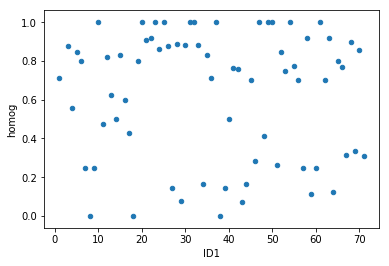

In [52]:
# slide 74 
out_edge_agg = out_edge_agg.reset_index(drop=False)

out_edge_agg.plot.scatter(x='ID1', y='homog')

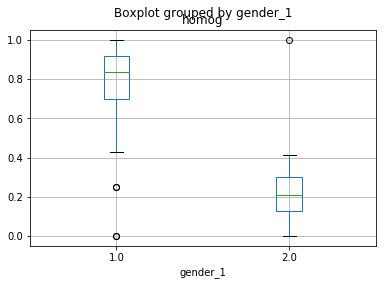

In [55]:
# slide 78
#homog_by_gender = out_edge_agg.groupby('gender_1')['homog'].mean()

out_edge_agg.boxplot(column='homog', by='gender_1')

## Reciprocated ties

In [56]:
# Check reciprocality
for i, (x, y) in out_edge[['ID1', 'ID2']].iterrows():
    if not out_edge[(out_edge.ID1==y) & (out_edge.ID2==x)].empty:
        out_edge.loc[i, 'reciprocated']=1
    else:
        out_edge.loc[i, 'reciprocated']=0

In [57]:
# drop duplicates
recipr = out_edge[['ID1', 'gender_1']].copy()
recipr = recipr.drop_duplicates()

In [58]:
recipr_agg = out_edge.groupby(['ID1', 'reciprocated'])['homog'].mean().unstack().reset_index(drop=False)
recipr = pd.merge(recipr, recipr_agg, on='ID1')

recipr.rename(columns={0: 'not mutual', 1:'mutual'}, inplace=True)

In [59]:
# slide 80
recipr['mutual'].describe()

count    57.000000
mean      0.666787
std       0.354980
min       0.000000
25%       0.400000
50%       0.750000
75%       1.000000
max       1.000000
Name: mutual, dtype: float64

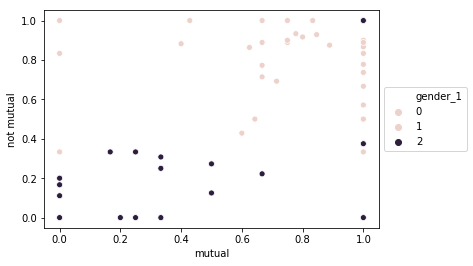

In [60]:
# slide 81
sns.scatterplot(x='mutual', y='not mutual', hue='gender_1', data=recipr).legend(loc='center left', bbox_to_anchor=(1, 0.5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c200da5f8>,
      dtype=object)

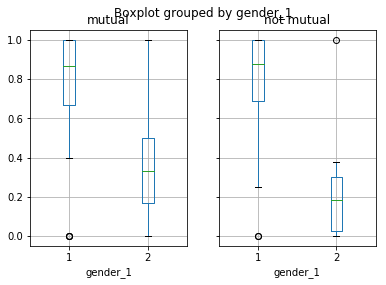

In [64]:
# slide 84
recipr.boxplot(column=['mutual', 'not mutual'], by='gender_1')